## Analysis of San Francisco Crime data in Summer 2014
#### [Communicating Data Science Results](https://www.coursera.org/learn/data-results) 
#### Assignment 1 

In this assignment, I analyzed the given sample criminal incident data from San Francisco during summer of 2014 trying to identify any patterns to draw some conclusions. Since there are many ideas to explore, as an exercise I just focus on the following areas:
1. What are the most frequent (Top 10) crimes during this time period?
2. How do incidents vary month to month?
3. Is there any pattern (esp. peak time) of incidents by time of a day? 
4. Is there any pattern (esp. peak day) of incidents by day of a week?

I implementated my solutions in R. The code and results are listed step-by-step as follows. The final conclusion and discussion of future works are at the end.


In [29]:
# Set up for plotting, png files are saved in "figures" folder
library(ggplot2)
if(!file.exists("figures")) dir.create("figures")


### Load data and inspect data fields

In [3]:
san<-read.csv("sanfrancisco_incidents_summer_2014.csv", head=T, sep=",",stringsAsFactors = F)

str(san)

'data.frame':	28993 obs. of  13 variables:
 $ IncidntNum: int  140734311 140736317 146177923 146177531 140734220 140734349 140734349 140734349 140738147 140734258 ...
 $ Category  : chr  "ARSON" "NON-CRIMINAL" "LARCENY/THEFT" "LARCENY/THEFT" ...
 $ Descript  : chr  "ARSON OF A VEHICLE" "LOST PROPERTY" "GRAND THEFT FROM LOCKED AUTO" "GRAND THEFT FROM LOCKED AUTO" ...
 $ DayOfWeek : chr  "Sunday" "Sunday" "Sunday" "Sunday" ...
 $ Date      : chr  "08/31/2014" "08/31/2014" "08/31/2014" "08/31/2014" ...
 $ Time      : chr  "23:50" "23:45" "23:30" "23:30" ...
 $ PdDistrict: chr  "BAYVIEW" "MISSION" "SOUTHERN" "RICHMOND" ...
 $ Resolution: chr  "NONE" "NONE" "NONE" "NONE" ...
 $ Address   : chr  "LOOMIS ST / INDUSTRIAL ST" "400 Block of CASTRO ST" "1000 Block of MISSION ST" "FULTON ST / 26TH AV" ...
 $ X         : num  -122 -122 -122 -122 -123 ...
 $ Y         : num  37.7 37.8 37.8 37.8 37.8 ...
 $ Location  : chr  "(37.7383221869053, -122.405646994567)" "(37.7617677182954, -122.435012093789

## Task #1 - Identify top 10 Crimes

   ####     - By major categories

In [5]:
san$Category<-factor(san$Category)
count_by_category<-as.data.frame(table(san$Category))
names(count_by_category)<-c('Category', 'Count')
top_10_crimes_count<-head(count_by_category[order(-count_by_category[,2]),], n=10)
top_10_crimes_count

,Category,Count
16,LARCENY/THEFT,9466
21,OTHER OFFENSES,3567
20,NON-CRIMINAL,3023
2,ASSAULT,2882
32,VEHICLE THEFT,1966
33,WARRANTS,1782
7,DRUG/NARCOTIC,1345
29,SUSPICIOUS OCC,1300
19,MISSING PERSON,1266
26,SECONDARY CODES,442


Saving 7 x 7 in image


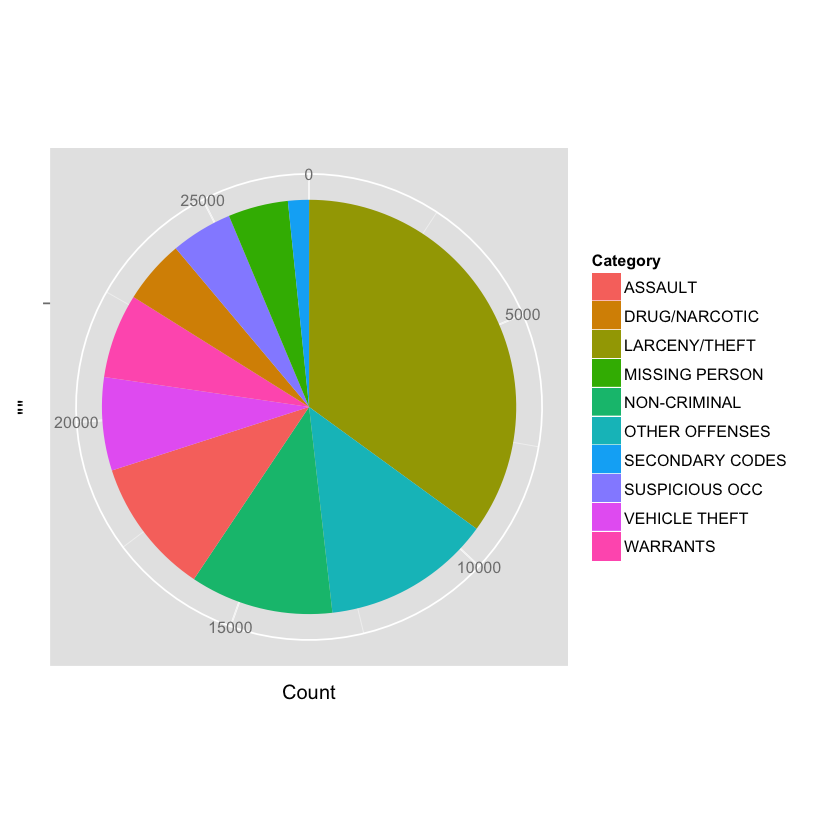

In [33]:
ggplot(top_10_crimes_count, aes(x='', y=Count, fill=Category)) + geom_bar(width=1, stat="identity") + coord_polar("y") 
ggsave(file="figures/Sanfrancisco_top_10_crime_category_summer2014_pie.png") 

#### - By crime descriptors (sub categories)

Saving 7 x 7 in image


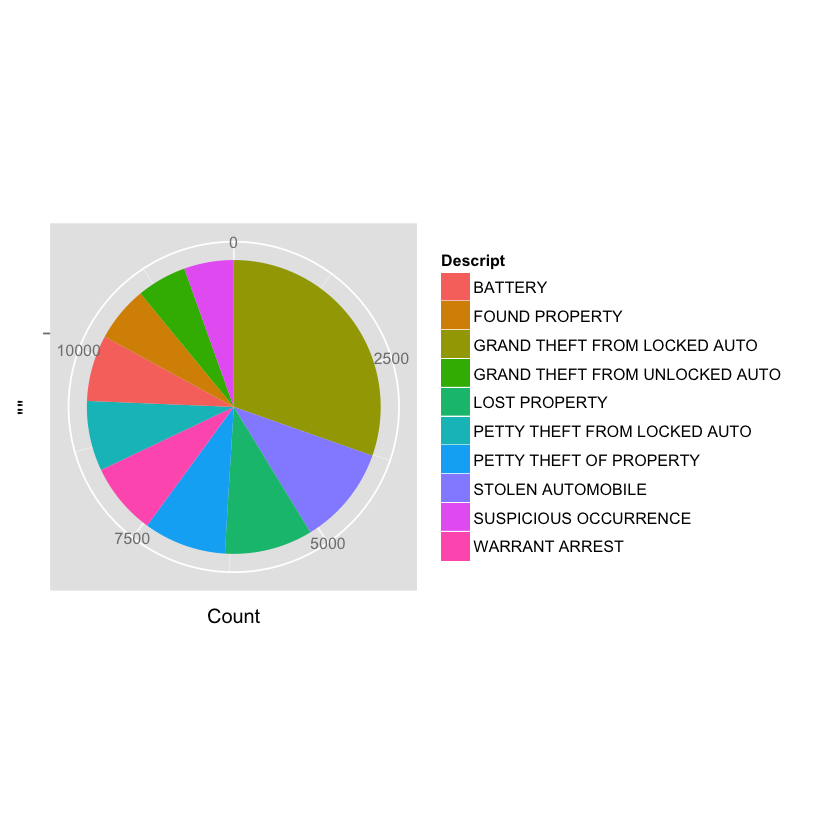

In [34]:
count_by_desc<-data.frame(table(factor(san$Descript)))
names(count_by_desc)<-c('Descript', 'Count')
top_10_crime_desc_count<-head(count_by_desc[order(-count_by_desc[,2]),], n=10)
ggplot(top_10_crime_desc_count, aes(x='', y=Count, fill=Descript)) + geom_bar(width=1, stat="identity") + coord_polar("y") 
ggsave(file="figures/Sanfrancisco_top_10_crime_descript_summer2014_pie.png")  

In [11]:
## Calculate percent of Top 10 incident categories in all incidents
paste0(formatC(sum(top_10_crimes_count$Count)/nrow(san)*100, format = 'f', digits = 2), "%")


[1] "93.26%"

### Conclusion for Task #1:
- "Larceny/Theft" is identified as the Number 1 incident in San Francisco during 2014 summer. In detailed classification we can see that thefts from Auto (locked and unlocked) dominates all reported incidents. It comes as no big surprise in a big, crowded, tourist city, especially during the peak traveling season in summer. Recommendations would be to use public transportation or bikes ;-)
- The top 10 crime categories take over 90% of all reported incidents so the rest analysis will ONLY use these 10 categories as they should represent the global pictures.

## Task #2  - Analysis by month-to-month

Saving 7 x 7 in image


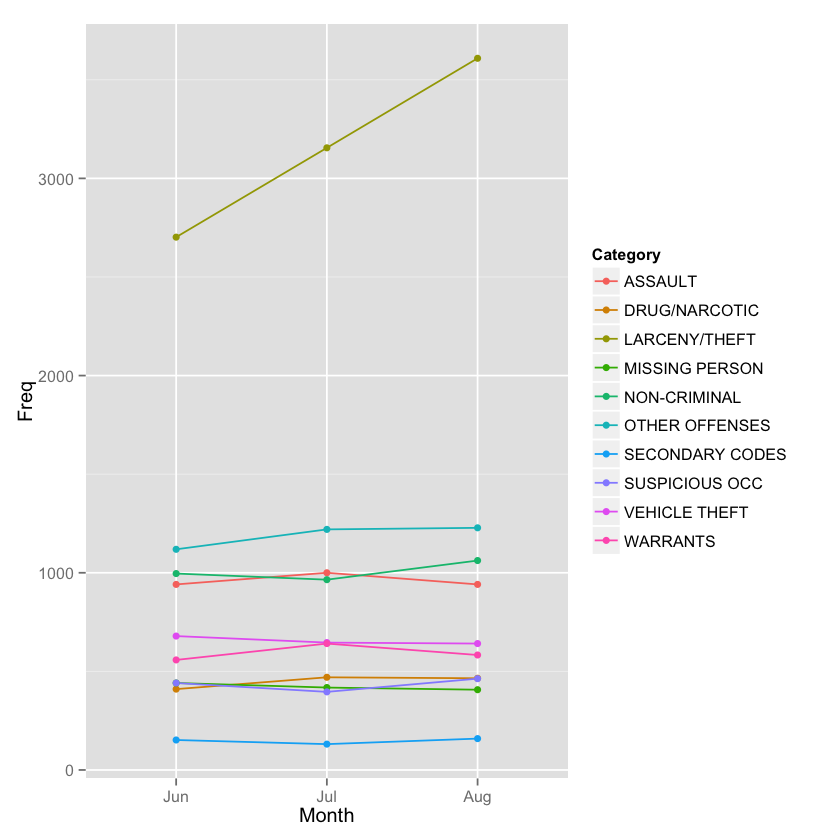

In [20]:
month<-strftime(strptime(san$Date, "%m/%d/%Y"), "%b")
month=factor(month, levels=c('Jun', 'Jul', 'Aug'))
by_month<-data.frame(Category=san$Category, Month=month)
top_10_crimes_by_month<-by_month[by_month$Category %in% top_10_crimes_count$Category,]
top_10_crimes_by_month$Category<-as.character(top_10_crimes_by_month$Category)
ggplot(data=data.frame(table(top_10_crimes_by_month)), aes(x=Month, y=Freq, group=Category, color=Category)) + geom_line() + geom_point()
ggsave(file="figures/Sanfrancisco_top_10_crimes_summer2014_by_month.png")

### Conclusion for Task #2:
- The incident counts do not vary much from month to month except for the "Lacerny/Theft" category, which has a continuous upper trend from June to August. 

## Task #3: - Incidents by hour of the day

Saving 7 x 7 in image


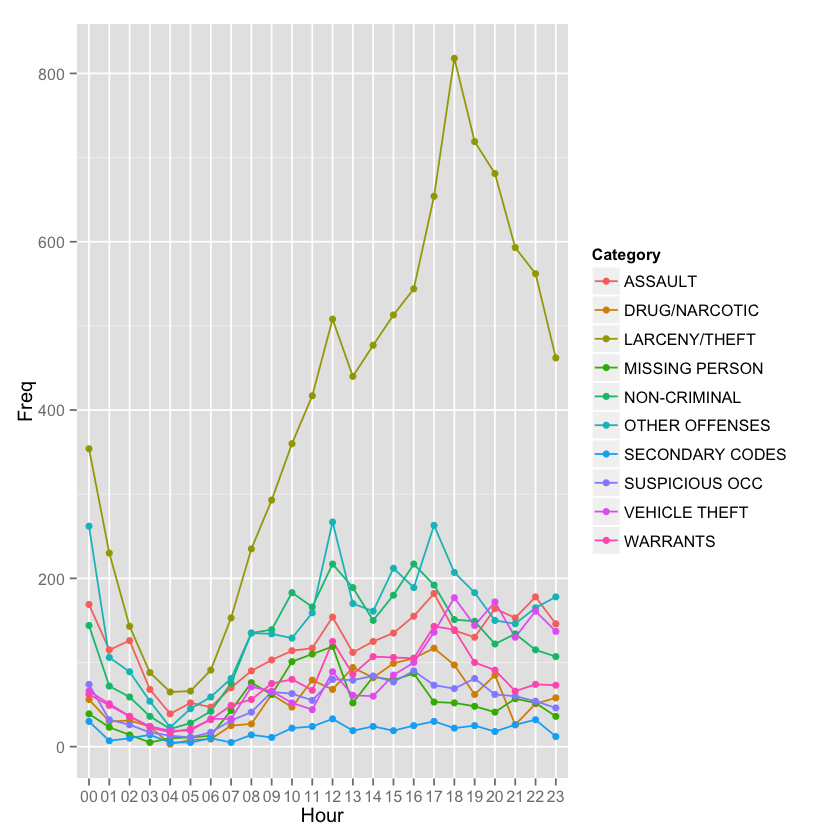

In [35]:
hour<-strftime(strptime(san$Time, "%H:%M"), "%H")
by_hour<-data.frame(Category=san$Category, Hour=hour)
top_10_crimes_by_hour<-by_hour[by_hour$Category %in% top_10_crimes_count$Category,]
top_10_crimes_by_hour$Category<-as.character(top_10_crimes_by_hour$Category)

ggplot(data=data.frame(table(top_10_crimes_by_hour)), aes(x=Hour, y=Freq, group=Category, color=Category)) + geom_line() + geom_point()
ggsave(file="figures/Sanfrancisco_top_10_crimes_summer2014_by_hour.png")

### Conclusion for task #3:
- Most categorires show a periodical pattern with two peak time of crimes.
- The major peaks happen around the evening rush hours/dinner time, ie, between 4 and 7pm.
- The minor peaks happen around noon.
- The larceny/theft category has the steepest slope suggesting crimes mostly likely to happen to tourists/residents during their eat time.  


## Task #4 - Incidents by day of the week

Saving 7 x 7 in image


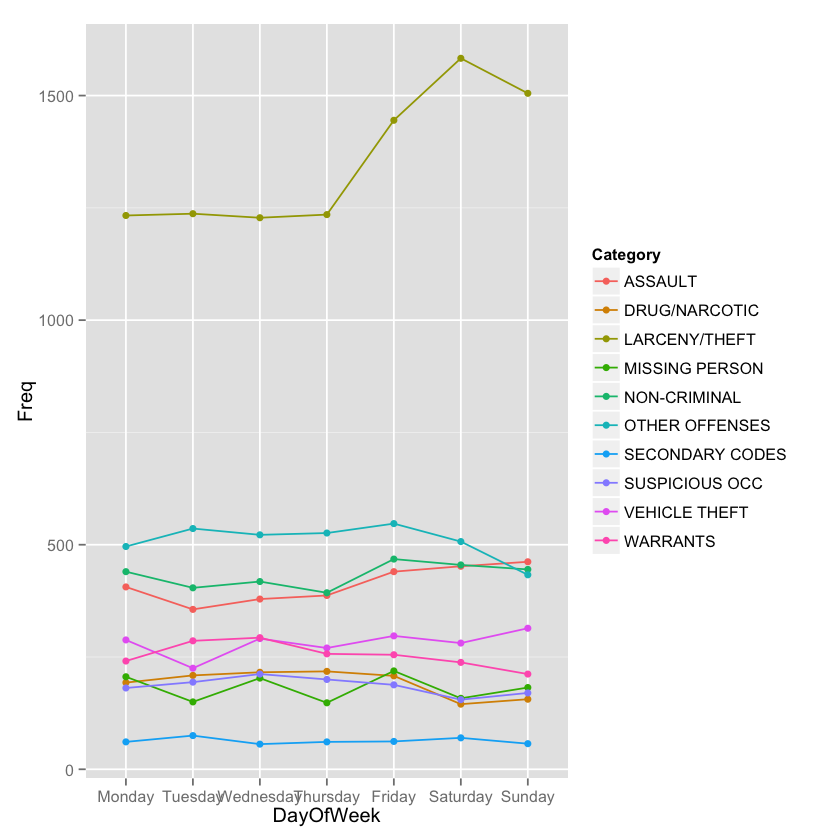

In [24]:
by_dayweek<-san[,c('Category', 'DayOfWeek')]
top_10_crimes_by_dayweek<-by_dayweek[by_dayweek$Category %in% top_10_crimes_count$Category,]
top_10_crimes_by_dayweek$Category<-as.character(top_10_crimes_by_dayweek$Category)
top_10_crimes_by_dayweek$DayOfWeek<-factor(top_10_crimes_by_dayweek$DayOfWeek, levels=c('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

ggplot(data=data.frame(table(top_10_crimes_by_dayweek)), aes(x=DayOfWeek, y=Freq, group=Category, color=Category))+ geom_line() + geom_point()
ggsave(file="figures/Sanfrancisco_top_10_crimes_summer2014_by_day_of_week.png")

### Conclusion for task #4:
- Most categorires do not show obvious variation during the week except for the Larceny/Theft category.
- The Larceny/theft category clearly shows a much higher incidents during the weekend compared with that in the work days.
- This seems to suggest the targest of Larceny/thefts are mainly tourists.


## Final conclusion
- The main conclusion is Larceny/Theft is the most frequent crimes in San Franciso during 2014 summer season. Most crimes peak at the lunch and dinner time and Larceny/Thefts also happen most during weekends and happen more in the late summer. 
- All above pattern seem to suggest a link between the crime rate and the city's tourist industry. The fact that larceny/thefts happen most frequently at eat time and weekends seem to suggest the tourists are the targets. The upper trend shown in Larceny/thefts in month-to-month comparison also can be explained by more tourists in the late summer in the city.

## Discussion
- Due to time constraints I only selected a few relatively simple topics to explore. Therefore the above conclusion might be overly simple. A deeper digging in the data might find evidences that contradict those conclusions.
- To prove the hypothesis of association between San Franciso's summer crime rate and the tourists one can conduct clustering analysis based on map coordinates (e.g. use Google map APIs to download distances between crime locations and run clustering algorithms like k-means) to see if larceny/thefts concentrate in favorite tourists areas.
- The month-to-month comparison is overly simple and lack of statistic powers. A day-to-day analysis of the whole summer might show patterns that differ with the month-to-month patterns. This should be a future work to explore.

### Future works:
- Explore associations between different crime categories, e.g. alcohol related with drug related, violent crimes with drug, etc. 
- Conduct day-to-day comparison of incident frequencies for the whole summer.
- Find most dangerous and safest area/districts in the city based on crime rate density (counts per square mile) 
- Analyze Seattle crime data and compare patterns 
- etc. ...